In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from k_means import *

### Data prep

In [3]:
root = "/media/dikra/PhD/DATA/DLC24_Data/tiny_all_bird_merged_coco"
images = f"{root}/images"
annotations = f"{root}/annotations"

In [4]:
train_file = open(f"{annotations}/train.json")
test_file = open(f"{annotations}/test.json")
train_data = json.load(train_file)
test_data = json.load(test_file)

In [5]:
train_ann = len(train_data["annotations"])
train_ann

414

In [6]:
cats = train_data["categories"][0]["keypoints"]
cats_dict = dict(zip(range(0,len(cats)), cats))
cats_dict

{0: 'back',
 1: 'bill',
 2: 'belly',
 3: 'breast',
 4: 'crown',
 5: 'forehead',
 6: 'left_eye',
 7: 'left_leg',
 8: 'left_wing_tip',
 9: 'left_wrist',
 10: 'nape',
 11: 'right_eye',
 12: 'right_leg',
 13: 'right_wing_tip',
 14: 'right_wrist',
 15: 'tail_tip',
 16: 'throat',
 17: 'neck',
 18: 'tail_left',
 19: 'tail_right',
 20: 'upper_spine',
 21: 'upper_half_spine',
 22: 'lower_half_spine',
 23: 'right_foot',
 24: 'left_foot',
 25: 'left_half_chest',
 26: 'right_half_chest',
 27: 'chin',
 28: 'left_tibia',
 29: 'right_tibia',
 30: 'lower_spine',
 31: 'upper_half_neck',
 32: 'lower_half_neck',
 33: 'left_chest',
 34: 'right_chest',
 35: 'upper_neck',
 36: 'left_wing_shoulder',
 37: 'left_wing_elbow',
 38: 'right_wing_shoulder',
 39: 'right_wing_elbow',
 40: 'upper_cere',
 41: 'lower_cere'}

In [118]:
all_keypoints = get_all_keypoints(train_data) # load all keypoint annotations
parsed_keypoints = parse_keypoints(all_keypoints) # parse keypoint annotations into (x, y, visibility) triples
indexed_keypoints = get_keypoints_dict(parsed_keypoints) # index keypoint with corresponding body part 
visible_keypoints = get_visible_keypoints(indexed_keypoints) # filter out invisible & occluded keypoints (keeping 1. and 2. visibility)
features = get_features(visible_keypoints) # turn dict into pandas dataframe for kmeans & visualisation manipulations
f'{len(features)} visible annotated keypoints'

'1951 visible annotated keypoints'

In [122]:
gt_labels = [list(i.keys()) for i in visible_keypoints]
gt_labels = sum(gt_labels, [])
len(gt_labels), np.unique(gt_labels)

(1951, array([ 1,  6,  8,  9, 10, 11, 13, 14, 15, 17, 23, 24]))

In [120]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features.shape

(1951, 2)

In [123]:
n_clusters = 10 # len(cats)

kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=10, max_iter=50, random_state=42)

# run Kmeans algo
kmeans.fit(scaled_features)

KMeans(init='random', max_iter=50, n_clusters=10, n_init=10, random_state=42)

In [124]:
centers = kmeans.cluster_centers_
predicted_labels = kmeans.labels_
len(predicted_labels), len(centers)

(1951, 10)

In [125]:
np.unique(gt_labels)

array([ 1,  6,  8,  9, 10, 11, 13, 14, 15, 17, 23, 24])

In [128]:
ground_truth = to_df(scaled_features, gt_labels)
ground_truth.sample(10)

,0,1,label
6,-0.933450,-0.445471,6
8,-0.074019,-0.495502,8
13,1.495873,-1.033330,13
15,0.551646,-0.254730,15
14,0.909169,-0.389187,14
10,0.235376,-0.395441,10
1,0.175788,1.587018,1
13,-0.504880,-0.801939,13
9,-0.222987,-0.285999,9
9,-0.711144,-0.482994,9


In [129]:
kmeans.inertia_, kmeans.n_iter_

(262.29882327435877, 12)

In [130]:
# Construct dataframe from predicted clusters
predicted_clusters = to_df(scaled_features, predicted_labels)
predicted_clusters.sample(10)

,0,1,label
1,1.209397,-1.236579,1
2,-1.845592,1.802775,2
9,-0.275699,-0.320395,9
5,1.388158,0.774022,5
8,1.353781,0.867830,8
5,1.074180,-0.332903,5
2,-1.582033,1.086713,2
5,1.163560,-0.420456,5
7,-1.359727,-0.173430,7
3,-0.108397,-0.598690,3


Text(0.5, 1.0, 'Train keypoints: 10 clusters')

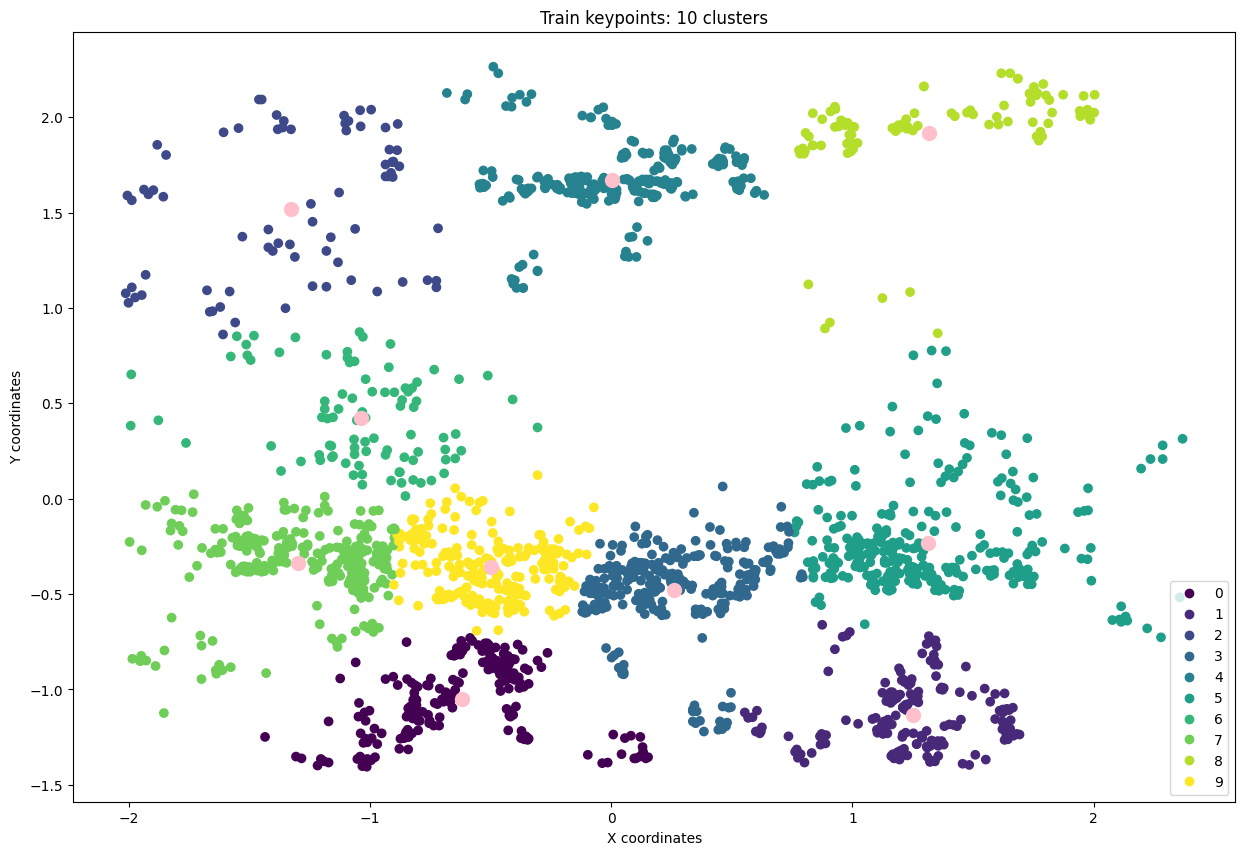

In [131]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(predicted_clusters[0], predicted_clusters[1], c=predicted_clusters['label'])
scatter2 = plt.scatter(centers[:, 0], centers[:, 1], c="pink", s=100)
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')

unique_labels = np.unique(predicted_clusters['label'])
handles, labels = scatter.legend_elements(prop="colors", num=len(unique_labels))
plt.legend(handles, unique_labels, loc="lower right", ncol=len(unique_labels)/n_clusters)
plt.title(f"Train keypoints: {n_clusters} clusters")

Text(0.5, 1.0, 'Ground Truth Train Keypoints')

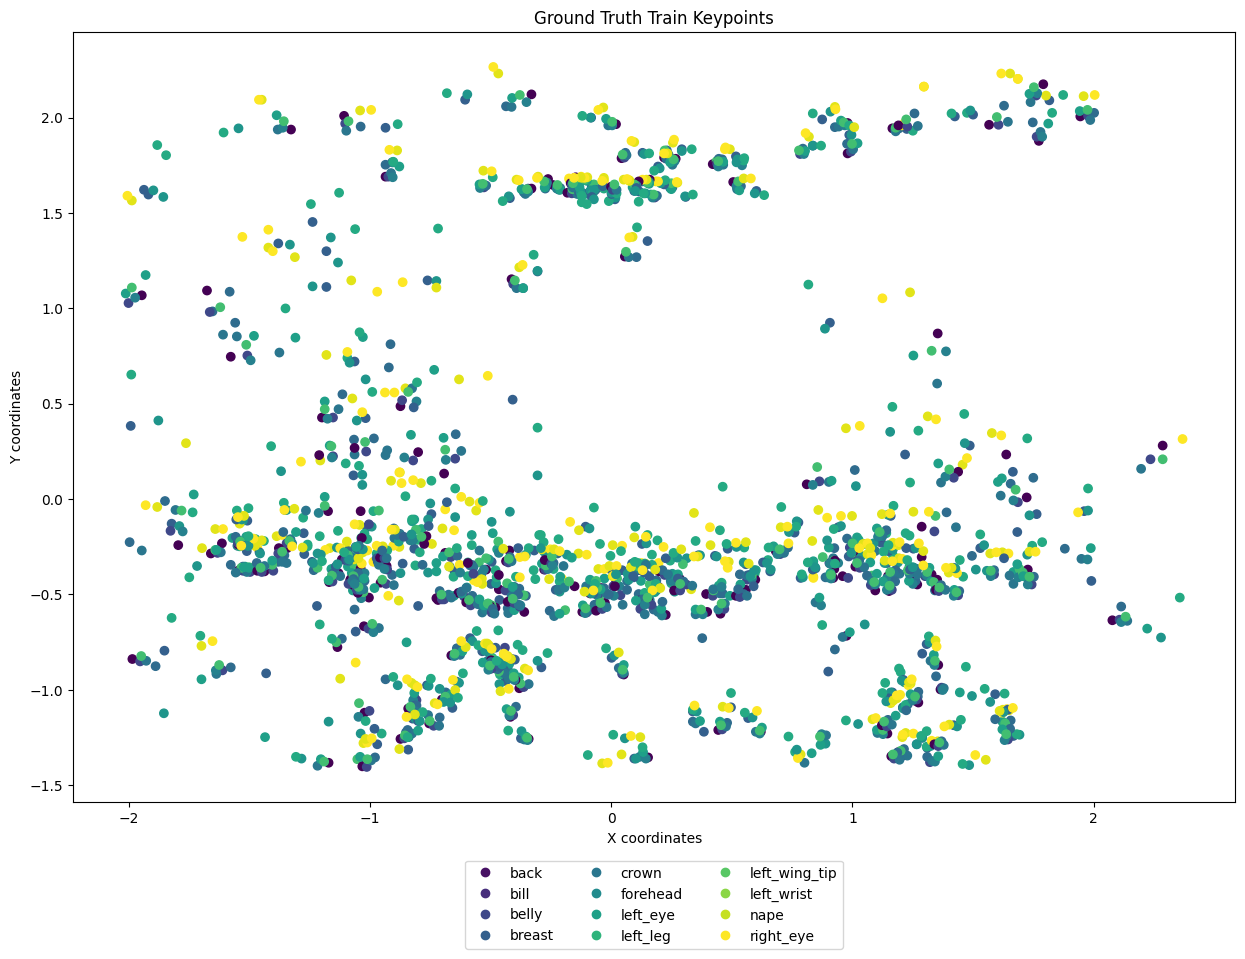

In [135]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(ground_truth[0], ground_truth[1], c=ground_truth['label'])
# scatter2 = plt.scatter(centers[:, 0], centers[:, 1], c="pink", s=100)
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')

unique_labels = np.unique(ground_truth['label'])
handles, labels = scatter.legend_elements(prop="colors", num=len(unique_labels))
plt.legend(handles, cats, loc="lower center", ncol=len(unique_labels)/4, bbox_to_anchor=(0.5, -0.2))
plt.title(f"Ground Truth Train Keypoints")